In [1]:
import torch
torch.__version__

'2.0.0+cu118'

In [2]:
torch.cuda.is_available()

True

In [48]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [3]:
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
%%capture
!pip install pyyaml==5.1
#!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git@v0.5'

In [9]:
import pandas as pd
import numpy as np

import torch, torchvision
import matplotlib.pyplot as plt
import json
import cv2
import numpy as np
from copy import deepcopy

In [5]:
from detectron2.modeling import build_model
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.structures.image_list import ImageList
from detectron2.data import transforms as T
from detectron2.modeling.box_regression import Box2BoxTransform
from detectron2.modeling.roi_heads.fast_rcnn import FastRCNNOutputs
from detectron2.structures.boxes import Boxes
from detectron2.layers import nms
from detectron2 import model_zoo
from detectron2.config import get_cfg

In [10]:
data = pd.read_csv('data/data_processed.csv',index_col=0)
data

,id,findings,impression,full-text,label
0,162,Heart size normal. Lungs are clear. XXXX are n...,Normal chest,Heart size normal. Lungs are clear. XXXX are n...,normal
1,1390,The heart size and pulmonary vascularity appea...,No evidence of active disease.,The heart size and pulmonary vascularity appea...,abnormal
2,604,The heart size and pulmonary vascularity appea...,1. No evidence of active disease.,The heart size and pulmonary vascularity appea...,abnormal
3,2699,The heart is normal in size and contour. The l...,No acute cardiopulmonary disease.,The heart is normal in size and contour. The l...,normal
4,2841,The heart is normal in size and contour. The l...,No acute cardiopulmonary disease.,The heart is normal in size and contour. The l...,normal
...,...,...,...,...,...
3950,2694,The heart is normal in size and contour. The l...,No acute cardiopulmonary disease.,The heart is normal in size and contour. The l...,normal
3951,2858,Heart size normal. Tortuous aorta. Sequela pri...,No acute cardiopulmonary finding.,Heart size normal. Tortuous aorta. Sequela pri...,abnormal
3952,2680,The lungs are clear. There is no pleural effus...,No acute pulmonary disease.,The lungs are clear. There is no pleural effus...,normal
3953,85,There are scattered calcified granulomas. No f...,No evidence of active disease.,There are scattered calcified granulomas. No f...,abnormal


In [50]:
cfg_path = "COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml"

def load_config_and_model_weights(cfg_path):
    cfg = get_cfg()
    cfg.merge_from_file(model_zoo.get_config_file(cfg_path))

    # ROI HEADS SCORE THRESHOLD
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5

    # Comment the next line if you're using 'cuda'
    cfg['MODEL']['DEVICE']='cpu'

    cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(cfg_path)

    return cfg

cfg = load_config_and_model_weights(cfg_path)

In [51]:
def get_model(cfg):
    # build model
    model = build_model(cfg)

    # load weights
    checkpointer = DetectionCheckpointer(model)
    checkpointer.load(cfg.MODEL.WEIGHTS)

    # eval mode
    model.eval()
    return model

model = get_model(cfg)

  proposal_generator.anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


In [37]:
def prepare_image_inputs(cfg, img_list):
    # Resizing the image according to the configuration
    transform_gen = T.ResizeShortestEdge(
                [cfg.INPUT.MIN_SIZE_TEST, cfg.INPUT.MIN_SIZE_TEST], cfg.INPUT.MAX_SIZE_TEST
            )
    img_list = [transform_gen.get_transform(img).apply_image(img) for img in img_list]

    # Convert to C,H,W format
    convert_to_tensor = lambda x: torch.Tensor(x.astype("float32").transpose(2, 0, 1))

    batched_inputs = [{"image":convert_to_tensor(img), "height": img.shape[0], "width": img.shape[1]} for img in img_list]

    # Normalizing the image
    num_channels = len(cfg.MODEL.PIXEL_MEAN)
    pixel_mean = torch.Tensor(cfg.MODEL.PIXEL_MEAN).view(num_channels, 1, 1)
    pixel_std = torch.Tensor(cfg.MODEL.PIXEL_STD).view(num_channels, 1, 1)
    normalizer = lambda x: (x - pixel_mean) / pixel_std
    images = [normalizer(x["image"]) for x in batched_inputs]

    # Convert to ImageList
    images =  ImageList.from_tensors(images,model.backbone.size_divisibility)
    
    return images, batched_inputs

In [53]:
def get_features(model, images):
    features = model.backbone(images.tensor)
    return features

In [39]:
def get_proposals(model, images, features):
    proposals, _ = model.proposal_generator(images, features)
    return proposals

In [40]:
def get_box_features(model, features, proposals):
    features_list = [features[f] for f in ['p2', 'p3', 'p4', 'p5']]
    box_features = model.roi_heads.box_pooler(features_list, [x.proposal_boxes for x in proposals])
    box_features = model.roi_heads.box_head.flatten(box_features)
    box_features = model.roi_heads.box_head.fc1(box_features)
    box_features = model.roi_heads.box_head.fc_relu1(box_features)
    box_features = model.roi_heads.box_head.fc2(box_features)

    box_features = box_features.reshape(1, box_features.shape[0], box_features.shape[1]) # depends on your config and batch size
    return box_features, features_list

In [41]:
def get_prediction_logits(model, features_list, proposals):
    cls_features = model.roi_heads.box_pooler(features_list, [x.proposal_boxes for x in proposals])
    cls_features = model.roi_heads.box_head(cls_features)
    pred_class_logits, pred_proposal_deltas = model.roi_heads.box_predictor(cls_features)
    return pred_class_logits, pred_proposal_deltas

In [42]:
def get_box_scores(cfg, pred_class_logits, pred_proposal_deltas):
    box2box_transform = Box2BoxTransform(weights=cfg.MODEL.ROI_BOX_HEAD.BBOX_REG_WEIGHTS)
    smooth_l1_beta = cfg.MODEL.ROI_BOX_HEAD.SMOOTH_L1_BETA

    outputs = FastRCNNOutputs(
        box2box_transform,
        pred_class_logits,
        pred_proposal_deltas,
        proposals,
        smooth_l1_beta,
    )

    boxes = outputs.predict_boxes()
    scores = outputs.predict_probs()
    image_shapes = outputs.image_shapes

    return boxes, scores, image_shapes

In [43]:
def get_output_boxes(boxes, batched_inputs, image_size):
    proposal_boxes = boxes.reshape(-1, 4).clone()
    scale_x, scale_y = (batched_inputs["width"] / image_size[1], batched_inputs["height"] / image_size[0])
    output_boxes = Boxes(proposal_boxes)

    output_boxes.scale(scale_x, scale_y)
    output_boxes.clip(image_size)

    return output_boxes

In [44]:
def select_boxes(cfg, output_boxes, scores):
    test_score_thresh = cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST
    test_nms_thresh = cfg.MODEL.ROI_HEADS.NMS_THRESH_TEST
    cls_prob = scores.detach().cpu()
    cls_boxes = output_boxes.tensor.detach().reshape(output_boxes.tensor.shape[0]//80,80,4).cpu()
    max_conf = torch.zeros((cls_boxes.shape[0]))
    for cls_ind in range(0, cls_prob.shape[1]-1):
        cls_scores = cls_prob[:, cls_ind+1]
        det_boxes = cls_boxes[:,cls_ind,:]
        keep = np.array(nms(det_boxes, cls_scores, test_nms_thresh))
        max_conf[keep] = torch.where(cls_scores[keep] > max_conf[keep], cls_scores[keep], max_conf[keep])
    keep_boxes = torch.where(max_conf >= test_score_thresh)[0]
    return keep_boxes, max_conf

In [45]:
MIN_BOXES=10
MAX_BOXES=100
def filter_boxes(keep_boxes, max_conf, min_boxes, max_boxes):
    if len(keep_boxes) < min_boxes:
        keep_boxes = np.argsort(max_conf).numpy()[::-1][:min_boxes]
    elif len(keep_boxes) > max_boxes:
        keep_boxes = np.argsort(max_conf).numpy()[::-1][:max_boxes]
    return keep_boxes

In [46]:
def get_visual_embeds(box_features, keep_boxes):
    return box_features[keep_boxes.copy()]

In [31]:
from tqdm.auto import tqdm
from PIL import Image

bgr_images = []
for image in tqdm(data.DCM Path):
    img = Image.open(image)
    img = np.asarray(img)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    bgr_images.append(img)

  0%|          | 0/100 [00:00<?, ?it/s]

In [32]:
len(bgr_images)

100

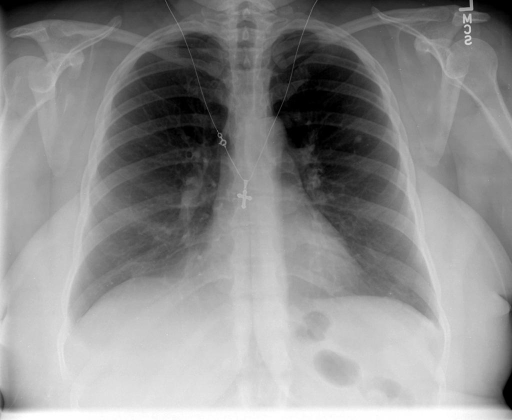

In [34]:
import numpy as np
from google.colab.patches import cv2_imshow
cv2_imshow(bgr_images[0])

In [54]:
from tqdm.auto import tqdm

visual_embeds = []

for image in tqdm(bgr_images):
    # Convert Image to Model Input
    image, batched_inputs = prepare_image_inputs(cfg, [image])

    # Get ResNet+FPN features
    features = get_features(model, image)

    # Get region proposals from RPN
    proposals = get_proposals(model, image, features)
  
    # Get Box Features for the proposals
    box_features, features_list = get_box_features(model, features, proposals)

    # Get prediction logits and boxes
    pred_class_logits, pred_proposal_deltas = get_prediction_logits(model, features_list, proposals)

    # Get FastRCNN scores and boxes
    boxes, scores, image_shapes = get_box_scores(cfg, pred_class_logits, pred_proposal_deltas)

    # Rescale the boxes to original image size
    output_boxes = [get_output_boxes(boxes[i], batched_inputs[i], proposals[i].image_size) for i in range(len(proposals))]

    # Select the Boxes using NMS
    temp = [select_boxes(cfg, output_boxes[i], scores[i]) for i in range(len(scores))]
    keep_boxes, max_conf = [], []
    for keep_box, mx_conf in temp:
        keep_boxes.append(keep_box)
        max_conf.append(mx_conf)

    # Limit the total number of boxes
    keep_boxes = [filter_boxes(keep_box, mx_conf, MIN_BOXES, MAX_BOXES) for keep_box, mx_conf in zip(keep_boxes, max_conf)]

    # Get the visual embedding
    visual_embed = [torch.tensor(get_visual_embeds(box_feature, keep_box)).to(device) for box_feature, keep_box in zip(box_features, keep_boxes)]
    visual_embeds.append(visual_embed[0])

  0%|          | 0/100 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
<ipython-input-54-ba2eb1352e66>:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  visual_embed = [torch.tensor(get_visual_embeds(box_feature, keep_box)).to(device) for box_feature, keep_box in zip(box_features, keep_boxes)]


In [56]:
visual_embeds[0].shape

torch.Size([100, 1024])

In [57]:
import pickle 

with open('visual_embeds.pkl', 'wb') as f:
    pickle.dump(visual_embeds, f)